### 00 OpenAI API KEY 로드하기

In [1]:
import os, json

with open('conf.json', 'r') as f:
    json_data = json.load(f)
    
os.environ['OPENAI_API_KEY'] = json_data['openai_config']['API_KEY']

### 01 모든 ETF의 심볼과 구성종목들의 심볼 로드하기

In [2]:
from data.fetch_data import fetch_data_from_db
import pandas as pd

query = """
    SELECT pdf.etf_tkr, pdf.child_stk_tkr
        FROM os_pdf_info pdf
        INNER JOIN os_stk_info stk
        ON pdf.child_stk_tkr=stk.stk_tkr
"""

ticker_df = pd.DataFrame(fetch_data_from_db(query=query)) 

ticker_list = list(set(ticker_df['child_stk_tkr'].to_list()))

### 02 yfinance에서 개별 주식들의 metadata와 사업개요 로드하기
- 테스트 속도 향상을 위해 23-09-11 일자 뉴스 데이터로 실행합니다

In [3]:
import yfinance as yf
from tqdm.auto import tqdm

yf_stk_info = yf.Tickers(" ".join(ticker_list))

for t in tqdm(ticker_list):
    
    # 이미 뉴스가 존재하면 패스합니다. 
    if os.path.isfile(f"./stk_infos/{t}.json"):
        continue

    parent_etfs = ticker_df[ticker_df['child_stk_tkr']==t]['etf_tkr'].to_list()

    yf_stk_info.tickers[t].info['parent_etfs'] = parent_etfs
    
    if "longBusinessSummary" not in yf_stk_info.tickers[t].info.keys():
        print(t)
        yf_stk_info.tickers[t].info["longBusinessSummary"] = "None"

    with open(f'./stk_infos/{t}.json', 'w') as f:
        json.dump(yf_stk_info.tickers[t].info, f, indent=4)

  0%|          | 0/712 [00:00<?, ?it/s]

In [4]:
from langchain.document_loaders import JSONLoader
from langchain.document_loaders import DirectoryLoader

def metadata_func(record: dict, metadata: dict) -> dict:
        
    for k, v in record.items():
        if k=='longBusinessSummary':
            continue
        
        if k == 'parent_etfs':
            metadata[k] = ",".join(record.get(k))
        
        if type(record.get(k)) not in [str, int, float]:
            continue
        
        metadata[k] = record.get(k)

    return metadata

loader = DirectoryLoader('./stk_infos',
                         glob='*.json', 
                         loader_cls=JSONLoader, 
                         loader_kwargs={'jq_schema': '.',
                                        'content_key': 'longBusinessSummary',
                                        'metadata_func': metadata_func})

In [5]:
documents = loader.load()

len(documents)

712

#### 02-1 벡터 데이터베이스 생성
- DB폴더가 생성됩니다.
- [중요] DB 폴더는 로컬 환경이 달라질때마다 새로 생성되어야 합니다. (ex, git clone을 받은 서버, 컴퓨터가 달라지면 새로 생성해주어야 합니다)
- 한 번 생성된 DB는 같은 로컬 환경에서 재사용할 수 있습니다. 즉, 아래 셀을 주석 처리 가능합니다

In [6]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=200) #10000자 씩 끊되, 200자 씩 겹치게 만든다.
texts = text_splitter.split_documents(documents)

print(len(texts))

persist_directory='db'

embedding = OpenAIEmbeddings(
    model='text-embedding-ada-002'
)

vectordb = Chroma.from_documents(
    documents=texts,
    embedding=embedding,
    persist_directory=persist_directory,
)

712


### 03 유사도 검색을 할 Keyword 산출하기
- 33개 ETF의 추종 지수 methology book에 기재되어있는 subcategory를 입력하였습니다(수동)

In [7]:
from core.gpt_semantic_search import get_vectordb, get_filter, get_similar_symbols

class CONFIG:
    etf_tkr="AIQ"

filter_list = get_filter(etf_tkr=CONFIG.etf_tkr)

with open(f'subcategory_infos/{CONFIG.etf_tkr}.json', 'r') as f:
    json_data = json.load(f)
    
vectordb = get_vectordb()
    
docs_list = vectordb.get(where={'$or': filter_list})

for i, subcategory in enumerate(json_data['subcategory_lists']):
    
    keyword = subcategory['description']
    
    similar_stk_list = get_similar_symbols( 
            vectordb=vectordb,
            keyword=keyword,
            filter_list=filter_list,
            k=5,
        )
    
    print("="*100)
    
    print("키워드:", keyword)
    print()
    
    print("키워드와 사업개요가 가장 유사한 기업들:", similar_stk_list)
    print()

키워드: This category includes companies that develop AI and use AI in their own products. Companies that have developed internal AI capabilities (organically or through acquisition) and are applying artificial intelligence technology to enhance their products and services are the focus. AI applications include but are not limited to language/image processing and recognition, automated communications, threat detection, recommendation generation, and other predictive analytics. The companies are considered for inclusion in this category based on the level of AI involvement of the companies.

키워드와 사업개요가 가장 유사한 기업들: ['INFA', 'INFA', 'INTC', 'INTC', 'ACN']

키워드: Companies that provide artificial intelligence capabilities to their customers as a service. Companies in this segment typically offer cloud-based platforms that allow their customers to apply artificial intelligence techniques without needing to make a direct investment in AI-related infrastructure.

키워드와 사업개요가 가장 유사한 기업들: ['INFA', '

In [8]:
from core.financial_filtering import get_lowest_PBR_stks, get_momentums

docs_list = vectordb.get(where={'$or': filter_list})

lowest_PBR_stks_tuple_list = get_lowest_PBR_stks(docs_list=docs_list)

tkr_list = []

for i, stk_pbr in enumerate(lowest_PBR_stks_tuple_list):
    print(stk_pbr)
    if i < 5:
        tkr_list.append(stk_pbr[-1])

(0.20179798, 'BIDU')
(0.20179798, 'BIDU')
(0.2626706, 'STNE')
(0.2626706, 'STNE')
(0.49416146, 'BZ')
(0.49416146, 'BZ')
(0.49793226, 'VSAT')
(0.49793226, 'VSAT')
(1.0785595, 'HPE')
(1.0785595, 'HPE')
(1.1891185, 'TWLO')
(1.1891185, 'TWLO')
(1.320185, 'DXC')
(1.320185, 'DXC')
(1.5749, 'ERIC')
(1.5749, 'ERIC')
(1.5758052, 'INTC')
(1.5758052, 'INTC')
(1.8860711, 'VRNT')
(1.8860711, 'VRNT')
(2.541446, 'OKTA')
(2.541446, 'OKTA')


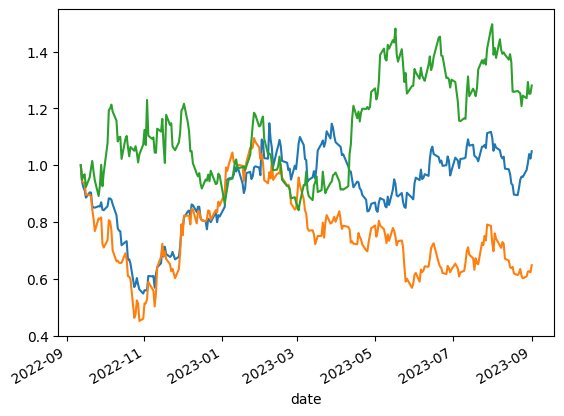

In [9]:
from data.get_data import get_prices_df

prices_df = get_prices_df(tickers=tkr_list, start_date="2022-09-11")

prices_df = prices_df / prices_df.iloc[0]

for i, col in enumerate(prices_df.columns):
    prices_df[col].plot()

In [10]:
momentum_tuple_list = get_momentums(filter_list=filter_list)

tkr_list = []

for i, stk_mmt in enumerate(momentum_tuple_list):
    print(stk_mmt)
    if i < 5:
        tkr_list.append(stk_mmt[-1])

(97.82, 'NVDA')
(86.2, 'META')
(72.97, 'ORCL')
(70.11, 'TTD')
(68.37, 'SNPS')
(68.27, 'AMZN')
(65.45, 'AAPL')
(64.26, 'CDNS')
(63.33, 'UBER')
(60.59, 'GOOGL')
(57.99, 'IONQ')
(54.55, 'CRM')


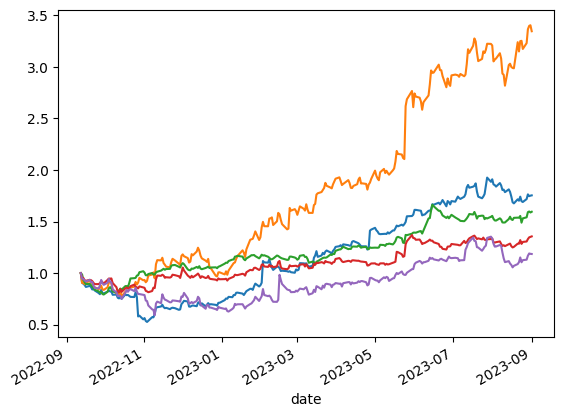

In [11]:
prices_df = get_prices_df(tickers=tkr_list, start_date="2022-09-11")

prices_df = prices_df / prices_df.iloc[0]

for col in prices_df.columns:
    prices_df[col].plot()